# Figure S3: Werner deconvolution solutions of ROSETTA-Ice flight lines 
This notebook produces supplementary figure 3 of Tankersley et al. 2022. The figure shows the Werner deconvolution solutions and resulting magnetic basement depths for a subset of ROSETTA-Ice flight lines, including the two lines (590 & 650) used for the tie to coincident OIB flight lines (flight 404).

In [5]:
# import necessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import copy
import scipy.interpolate 
import pygmt
from matplotlib import gridspec
import matplotlib.image as mpimg
import os

In [6]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Load data
output from *Tankersley2020_GRL.ipynb*

In [9]:
oib_mag_404_590 = pd.read_csv("../data/results/oib_mag404.59.csv", header=0, index_col=None,sep=',')
oib_404_590 = pd.read_csv("../data/results/oib404.59.csv", header=0, index_col=None,sep=',')
oib_basement_404_590 = pd.read_csv("../data/results/oib_basement404.59.csv", header=0, index_col=None,sep=',')

oib_mag_404_650 = pd.read_csv("../data/results/oib_mag404.65.csv", header=0, index_col=None,sep=',')
oib_404_650 = pd.read_csv("../data/results/oib404.65.csv", header=0, index_col=None,sep=',')
oib_basement_404_650 = pd.read_csv("../data/results/oib_basement404.65.csv", header=0, index_col=None,sep=',')

full_rs_mag = pd.read_csv("../data/results/rs_mag.csv", header=0, index_col=None,sep=',')
full_rs = pd.read_csv("../data/results/rs.csv", header=0, index_col=None,sep=',')
full_rs_basement = pd.read_csv("../data/results/rs_basement.csv", header=0, index_col=None,sep=',')

Distance_bins = full_rs_basement.columns[1]
# print(Distance_bins)
Depth_bins = full_rs_basement.columns[10]
# print(Depth_bins)

## Sample basement grid

In [10]:
# sample gridded basement onto dataframe
# move x and y cols to front of df
full_rs = full_rs[ ['y'] + [ col for col in full_rs.columns if col != 'y' ] ]
full_rs = full_rs[ ['x'] + [ col for col in full_rs.columns if col != 'x' ] ]
full_rs = pygmt.grdtrack(points=full_rs, 
                    grid='../data/results/Ross_Embayment_basement_filt.nc', 
                    newcolname='sampled_filtered_basement')

## Plotting function

In [15]:
def plot_ROSETTA_subplots(Line, save_as_png=True):
    global fig, rs_mag, rs, rs_basement
    fig = plt.figure(facecolor='w')
    gs = gridspec.GridSpec(2,1, height_ratios=[3,1])
    ax0 = fig.add_subplot(gs[0])
    
    rs = full_rs[full_rs.Line==Line]
    rs_mag = full_rs_mag[full_rs_mag.Line==Line]
    rs_basement = full_rs_basement[full_rs_basement.Line==Line]
    
    if Line in [590, 650]: # plot ROSETTA-OIB comparisons, x-axis is X
    
        if Line in [590,]:
            oib_mag = oib_mag_404_590 
            oib = oib_404_590
            oib_basement = oib_basement_404_590
        elif Line in [650,]:
            oib_mag = oib_mag_404_650 
            oib = oib_404_650
            oib_basement = oib_basement_404_650
        
        # bedmap2 bathymetry
        ax0.plot(rs.x, rs.bedmap2_bed, c='mediumturquoise', 
                 linewidth=1.5, label='Bathymetry')

        # OIB basement 
        ax0.plot(oib_basement.x, oib_basement.filt_clip,  c='blue', 
                 linewidth=2, label='OIB Basement')
        
        # interpolated ROSETTA basement
        ax0.plot(rs_basement.x, rs_basement.filt_clip, 
             linewidth=2, c='darkorange', label='Magnetic basement')
        
        # uncertainty bounds
        error=480
        ax0.fill_between(rs_basement.x, 
                         rs_basement.filt_clip-error, 
                         rs_basement.filt_clip+error,
                         facecolor='darkorange', alpha=.3)
        
        # ROSETTA Werner dike solutions 
        ax0.scatter(rs.x, rs.Depth, 
                    s = 1.5, marker='.', edgecolor='none', 
                    facecolor='k', label='All solutions')
    
        # ROSETTA filtered solutions, scaled by Susc
        ax0.scatter(rs.x[rs[Depth_bins].notna()], 
                    rs.Depth[rs[Depth_bins].notna()],
                    s = rs[rs[Depth_bins].notna()].Susc*3, 
                    marker='o', edgecolors='k', facecolors='none', 
                    linewidth=.8, label='Filtered solutions')
        
        # binned ROSETTA basement solutions
        ax0.scatter(rs_basement.x[rs_basement.binned==1], 
                    rs_basement[Depth_bins][rs_basement.binned==1], 
                    marker='X', c='darkorange', s=100, edgecolors='k', 
                    linewidth=.5, label='Binned solutions')
    
        ### ROSETTA magnetics    
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(rs_mag.x, rs_mag.Mag_anom_draped_1000, 
                    s=.05, c='magenta', label='ROSETTA')
        #### OIB magnetics
        ax3 = fig.add_subplot(gs[1],  sharex=ax0)
        ax3.patch.set_alpha(0)
        ax3.scatter(oib_mag.x, oib_mag.Mag_anom_draped_1000, 
                    s=.05, c='k', label='OIB')
        ax3.yaxis.tick_left()
        ax3.tick_params(axis='both', labelsize=8)
        ax3.set_ylabel('Magnetic anomaly (nT)', size=8, labelpad=10)
        ax1.annotate(text='OIB', xy=(0.01,0.8), xycoords='axes fraction', fontsize=6)    
        ax1.annotate(text='ROSETTA', xy=(0.01,0.9), xycoords='axes fraction', 
                 fontsize=6, color='magenta')
        ax1.tick_params(axis='both', labelsize=8)
        ax1.tick_params(axis='y', labelsize=8, colors='magenta', pad=0)
        ax0.tick_params(axis='both', labelsize=8)
        
        if Line==590:
            ax0.text(x=-100000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=150000, y=-400, s='Western Ross Basin', fontsize=8)
            ax0.set_title('ROSETTA Line 590 / OIB Line 404')
            
        elif Line==650:
            ax0.text(x=-350000, y=-400, s='Roosevelt Island', fontsize=8)
            ax0.text(x=-120000, y=-400, s='Mid-Shelf High', fontsize=8)
            ax0.text(x=100000, y=-400, s='Western Ross Basin', fontsize=8)
            ax1.set_yticks(ticks=(-900,-1100))
            ax0.set_title('ROSETTA Line 650 / OIB Line 404')
            
        ax0.set_xlim(rs.x.min(), rs.x.max())
        ax1.set_xlabel('Easting (km)', size=8)
        ax1.yaxis.tick_left()
        ax0.grid(axis='x', which='major', alpha=0.8)
        ax0.grid(axis='x', which='minor', alpha=0.3)
        
        ax3.tick_params(axis='x', which='both', labelbottom=False) # remove tick labels
    
        ax1.xaxis.set_major_locator(ticker.MultipleLocator(100000))
        ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20000))
        
    else: #plot other ROSETTA lines, x-axis is DISTANCE
        rs=rs.dropna(subset='Distance')
        #vertical lines of bin size
        ax0.vlines(rs[Distance_bins].unique(),ymin=-10000, ymax=0, color='k', linewidth=1).set_alpha(.2)    

        # bedmap2 bathymetry
        ax0.plot(rs.Distance, rs.bedmap2_bed, c='mediumturquoise', 
                 linewidth=1.5, label='Bathymetry')

        # ROSETTA sampled gridded basement
        ax0.plot(rs.Distance[rs.sampled_filtered_basement.notna()], 
                 rs.sampled_filtered_basement[rs.sampled_filtered_basement.notna()], 
                 c='b', label='Sampled basement grid')
        
        # interpolated ROSETTA basement
        # ax0.plot(rs_basement.Distance, rs_basement.filt_clip, 
        #          linewidth=2, c='darkorange', label='Magnetic basement')
        
        # uncertainty bounds
        error=480
        ax0.fill_between(rs.Distance[rs.sampled_filtered_basement.notna()], 
                         rs.sampled_filtered_basement[rs.sampled_filtered_basement.notna()]-error, 
                         rs.sampled_filtered_basement[rs.sampled_filtered_basement.notna()]+error,
                         facecolor='blue', alpha=.3)
        # ax0.fill_between(rs_basement.Distance, 
        #          rs_basement.filt_clip-error, 
        #          rs_basement.filt_clip+error,
        #          facecolor='darkorange', alpha=.3)
        
        # ROSETTA Werner dike solutions 
        ax0.scatter(rs.Distance, rs.Depth, s = 1.5, marker='.', edgecolor='none', 
                    facecolor='k', label='All solutions')
        
    
        # ROSETTA filtered solutions, scaled by Susc
        ax0.scatter(rs.Distance[rs[Depth_bins].notna()],
                    rs.Depth[rs[Depth_bins].notna()],
                    s = rs[rs[Depth_bins].notna()].Susc*3,
                    marker='o', edgecolors='k', facecolors='none', 
                    linewidth=.8, label='Filtered solutions')

        # binned ROSETTA basement solutions
        ax0.scatter(rs_basement.Distance[rs_basement.binned==1], 
                    rs_basement[Depth_bins][rs_basement.binned==1], 
                    marker='X',  c='darkorange', s=100, edgecolors='k', 
                    linewidth=.5, label='Binned solutions', zorder=15)
    
        # ROSETTA magnetics  
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.scatter(rs_mag.Distance, rs_mag.Mag_anom_draped_1000, s=.05, 
                    c='r', label='ROSETTA')
        ax1.yaxis.set_label_position("left")
        ax1.set_ylabel('Magnetic anomaly (nT)', size=8)
        ax0.set_title('ROSETTA Line '+str(Line))
        ax1.set_xlabel('Distance (km)', size=8) 
        
        # make x-axes in the same direction 
        if Line < 999: # reverse x axis if flight is West to East
            if rs.Distance[rs.x.idxmin()] > rs.Distance[rs.x.idxmax()]:
                ax1.set_xlim(rs.Distance.max(), rs.Distance.min()) 
                ax1.xaxis.set_major_locator(ticker.MultipleLocator(100000))
                ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
                ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20000))    
            else:
                ax1.set_xlim(rs.Distance.min(), rs.Distance.max())
                ax1.xaxis.set_major_locator(ticker.MultipleLocator(100000))
                ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
                ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20000))
            ax0.text(0, 1.01, 'East', fontsize=8, transform=ax0.transAxes, ha='left')
            ax0.text(1, 1.01, 'West', fontsize=8, transform=ax0.transAxes, ha='right')
        elif Line > 999: # reverse x axis if flight is South to North
            if rs.Distance[rs.y.idxmin()] < rs.Distance[rs.y.idxmax()]:
                ax1.set_xlim(rs.Distance.max(), rs.Distance.min()) 
                ax1.xaxis.set_major_locator(ticker.MultipleLocator(100000))
                ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
                ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20000))  
            else:
                ax1.set_xlim(rs.Distance.min(), rs.Distance.max())
                ax1.xaxis.set_major_locator(ticker.MultipleLocator(100000))
                ax1.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x/1000), ',')))
                ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20000))  
            ax0.text(0, 1.01, 'South', fontsize=8, transform=ax0.transAxes, ha='left')
            ax0.text(1, 1.01, 'North', fontsize=8, transform=ax0.transAxes, ha='right')
      
    if Line==270:
        ax0.text(x=400000, y=-400, s='Crary Trough', fontsize=8)
        ax0.text(x=280000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=150000, y=-400, s='Western Ross Basin', fontsize=8)
    if Line==310:
        ax0.text(x=400000, y=-400, s='Crary Trough', fontsize=8)
        ax0.text(x=300000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=170000, y=-400, s='Western Ross Basin', fontsize=8)
    if Line==410:
        ax0.text(x=60000, y=-400, s='Siple Dome Basin', fontsize=8)
        ax0.text(x=300000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=500000, y=-400, s='Western Ross Basin', fontsize=8)
    if Line==430:
        ax0.text(x=720000, y=-400, s='Siple Dome Basin', fontsize=8)
        ax0.text(x=470000, y=-400, s='Mid-Shelf High', fontsize=8)
        ax0.text(x=220000, y=-400, s='Western Ross Basin', fontsize=8)
    """
    parameters for all lines
    """
    ax1.tick_params(axis='both', labelsize=8)
    ax0.tick_params(axis='both', labelsize=8)
    
    ax0.set_ylim(-8000, 0)
    ax0.set_yticks((-6000, -4000, -2000, 0))
    ax0.set_yticklabels((-6, -4, -2, 0))
    
    ax1.grid(axis='x', which='major', alpha=0.8)
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax0.set_ylabel('Depth (km)', size=8)

    lgnd = ax0.legend(loc='lower right', fontsize=6, markerscale=4,framealpha=1)
    lgnd.legendHandles[-5]._sizes = [20]
    lgnd.legendHandles[-4]._sizes = [20]
    lgnd.legendHandles[-3]._sizes = [10]
    lgnd.legendHandles[-2]._sizes = [30]
    lgnd.legendHandles[-1]._sizes = [40]
    
    fig.subplots_adjust(hspace=0)
    ax0.tick_params(axis='x', which='both', labelbottom=False) # remove tick labels
     
    if save_as_png==True:
        out="outputs/all_ROSETTA_lines/ROSETTA_line_"+str(Line)+".png"
        fig.savefig(out, dpi=500)
    plt.close()

## Individual line plots

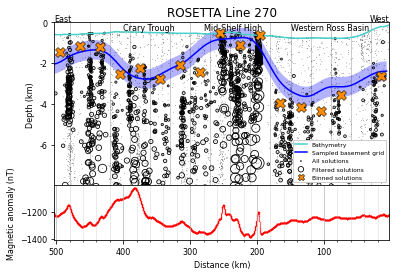

In [14]:
# plot_ROSETTA_subplots(Line=270, save_as_png=False) #270,310,410,430,590,650

## Subplots function

In [16]:
def plot_figs_as_subplots(lines, save_as_png=False):
    for x in lines:
        plot_ROSETTA_subplots(Line=x)
    plt.figure(figsize=(20,20))
    images=[]
    string1 = 'outputs/all_ROSETTA_lines/ROSETTA_line_'
    string2 = '.png'
    fig_list = [string1 + str(x) + string2 for x in lines]
    for f in fig_list:
        images.append(mpimg.imread(f))
    for i, image in enumerate(images):
        if len(fig_list)>1:
            rows=int(np.ceil(len(fig_list)/2))
            cols=int(np.ceil(len(fig_list)/rows))
            plt.subplot(rows, cols, i + 1)
            label=['a','b','c','d','e','f']
            plt.text(200,200, label[i], fontsize='40') # add labels to each subplot
        else:
            plt.subplot(1, 1, i + 1)
        plt.axis("off")
        plt.imshow(image, aspect='equal')

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout(pad=0, 
                     w_pad=-7, 
                     h_pad=-1)
    if save_as_png==True:
        plt.savefig("outputs/FigS3_RIS_transects.jpg", dpi=200)
    plt.show()
    plt.close()
    
plt.show()

## Make figure

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/all_ROSETTA_lines/ROSETTA_line_270.png'

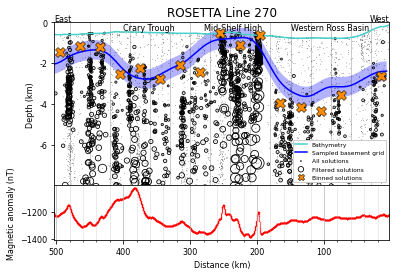

In [17]:
plot_figs_as_subplots(lines=(270,310,410,430,590,650), save_as_png=True)

## Output all ROSETTA-Ice lines as .png files

In [ ]:
# unique_lines = full_rs.Line.unique()
# 
# for l in unique_lines:
#     plot_ROSETTA_subplots(Line=l)